In [1]:
import sys
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from pathlib import Path

# Add Jorg to path
sys.path.append('/Users/jdli/Project/Korg.jl/Jorg/src')

# Import Jorg modules
from jorg.synthesis import format_abundances, interpolate_atmosphere
from jorg.statmech.chemical_equilibrium import chemical_equilibrium
from jorg.statmech.partition_functions import create_default_partition_functions
from jorg.statmech.molecular import create_default_log_equilibrium_constants
from jorg.continuum.core import total_continuum_absorption
from jorg.lines.hydrogen_lines_simple import hydrogen_line_absorption
from jorg.constants import SPEED_OF_LIGHT, BOLTZMANN_K


In [3]:
"""Execute the complete Jorg pipeline from MARCS to total opacity."""

print("🌟 JORG COMPLETE PIPELINE: MARCS → EOS → TOTAL OPACITY")
print("=" * 65)
print("Demonstrating the full stellar atmosphere opacity calculation")
print()

# =================================================================
# STEP 1: STELLAR PARAMETERS & MARCS ATMOSPHERE
# =================================================================
print("📊 STEP 1: Stellar Parameters & MARCS Atmosphere")
print("-" * 50)

# Define stellar parameters (solar-like star)
stellar_params = {
    'Teff': 5778.0,     # K (effective temperature)
    'logg': 4.44,       # cgs (surface gravity)
    'm_H': 0.0,         # [M/H] = 0.0 (solar metallicity)
    'alpha_H': 0.0,     # [α/H] = 0.0 (solar alpha enhancement)
    'vmic': 2.0         # km/s (microturbulence)
}

print(f"Stellar Parameters:")
for param, value in stellar_params.items():
    print(f"   • {param} = {value}")

# Format abundance vector for all elements
A_X = format_abundances(stellar_params['m_H'], stellar_params['alpha_H'])
print(f"   • Generated abundance vector: {len(A_X)} elements")

# Interpolate MARCS atmosphere model
print("\n🔄 Interpolating MARCS atmosphere model...")
atmosphere = interpolate_atmosphere(
    stellar_params['Teff'], 
    stellar_params['logg'], 
    A_X
)

print(f"✅ MARCS atmosphere interpolated:")
print(f"   • Layers: {atmosphere['n_layers']}")
print(f"   • Temperature range: {atmosphere['temperature'].min():.0f} - {atmosphere['temperature'].max():.0f} K")
print(f"   • Pressure range: {atmosphere['pressure'].min():.1e} - {atmosphere['pressure'].max():.1e} dyn/cm²")
print(f"   • Density range: {atmosphere['density'].min():.1e} - {atmosphere['density'].max():.1e} g/cm³")

🌟 JORG COMPLETE PIPELINE: MARCS → EOS → TOTAL OPACITY
Demonstrating the full stellar atmosphere opacity calculation

📊 STEP 1: Stellar Parameters & MARCS Atmosphere
--------------------------------------------------
Stellar Parameters:
   • Teff = 5778.0
   • logg = 4.44
   • m_H = 0.0
   • alpha_H = 0.0
   • vmic = 2.0
   • Generated abundance vector: 92 elements

🔄 Interpolating MARCS atmosphere model...
✅ MARCS atmosphere interpolated:
   • Layers: 72
   • Temperature range: 5221 - 15000 K
   • Pressure range: 2.8e-06 - 9.6e-02 dyn/cm²
   • Density range: 8.3e-18 - 1.0e-13 g/cm³


In [4]:
print(f"\n🧮 STEP 2: Chemical Equilibrium (Equation of State)")
print("-" * 55)

# Initialize partition functions and equilibrium constants
print("🔄 Creating partition functions and molecular equilibrium constants...")
species_partition_functions = create_default_partition_functions()
log_equilibrium_constants = create_default_log_equilibrium_constants()

print(f"✅ EOS components initialized:")
print(f"   • Partition functions: {len(species_partition_functions)} species")
print(f"   • Equilibrium constants: {len(log_equilibrium_constants)} molecular reactions")

# Prepare elemental abundances and ionization energies
absolute_abundances = {}
for Z in range(1, min(len(A_X), 31)):  # First 30 elements
    absolute_abundances[Z] = float(A_X[Z-1])

ionization_energies = {
    1: (13.6, 0.0, 0.0),     # H (eV)
    2: (24.6, 54.4, 0.0),    # He
    6: (11.3, 24.4, 47.9),   # C
    7: (14.5, 29.6, 47.4),   # N
    8: (13.6, 35.1, 54.9),   # O
    26: (7.9, 16.2, 30.7),   # Fe
    # Add more elements as needed
}

# Solve chemical equilibrium for atmospheric layers
print("\n🔄 Solving chemical equilibrium for all atmospheric layers...")
layer_solutions = []

# Sample layers (every ~10% for demonstration)
layer_indices = range(0, atmosphere['n_layers'], max(1, atmosphere['n_layers']//10))

for i in layer_indices:
    T = float(atmosphere['temperature'][i])
    P = float(atmosphere['pressure'][i])
    
    # Calculate total number density from ideal gas law
    k_B = 1.38e-16  # erg/K
    nt = P / (k_B * T)
    
    # Initial electron density estimate from atmosphere
    ne_initial = float(atmosphere['electron_density'][i])
    
    try:
        # Solve chemical equilibrium
        ne_converged, number_densities = chemical_equilibrium(
            T, nt, ne_initial,
            absolute_abundances,
            ionization_energies,
            species_partition_functions,
            log_equilibrium_constants
        )
        
        layer_solutions.append({
            'layer_index': i,
            'temperature': T,
            'pressure': P,
            'electron_density': ne_converged,
            'number_densities': number_densities,
            'total_density': nt
        })
        
        # Show progress for first few layers
        if len(layer_solutions) <= 3:
            nH_I = number_densities.get('H_I', 0.0)
            nHe_I = number_densities.get('He_I', 0.0)
            print(f"   • Layer {i:2d}: T={T:4.0f}K, ne={ne_converged:.2e} cm⁻³, nH_I={nH_I:.2e} cm⁻³")
            
    except Exception as e:
        print(f"   ⚠️  Layer {i}: EOS convergence failed ({str(e)[:50]}...)")
        continue

print(f"✅ Chemical equilibrium solved for {len(layer_solutions)} layers")


🧮 STEP 2: Chemical Equilibrium (Equation of State)
-------------------------------------------------------
🔄 Creating partition functions and molecular equilibrium constants...
✅ Loaded 275 Korg.jl partition functions
Setting up molecular equilibrium constants...
Loading 282 molecular species from Barklem & Collet 2016 data
Successfully loaded 282 molecular equilibrium constants
Loaded 282 diatomic + 6 polyatomic species
Total molecular species available: 288
✅ EOS components initialized:
   • Partition functions: 275 species
   • Equilibrium constants: 288 molecular reactions

🔄 Solving chemical equilibrium for all atmospheric layers...
   • Layer  0: T=5221K, ne=3.82e+05 cm⁻³, nH_I=0.00e+00 cm⁻³
   • Layer  7: T=5221K, ne=3.84e+05 cm⁻³, nH_I=0.00e+00 cm⁻³
   • Layer 14: T=5221K, ne=3.94e+05 cm⁻³, nH_I=0.00e+00 cm⁻³
✅ Chemical equilibrium solved for 11 layers


In [5]:
# =================================================================
# STEP 3: TOTAL OPACITY CALCULATION
# =================================================================
print(f"\n🌈 STEP 3: Total Opacity Calculation")
print("-" * 40)

# Define wavelength grid for opacity calculation
wavelength_config = {
    'range_A': (5000, 7000),    # Wavelength range in Angstroms
    'n_points': 200             # Number of wavelength points
}

wavelengths_A = jnp.linspace(*wavelength_config['range_A'], wavelength_config['n_points'])
wavelengths_cm = wavelengths_A * 1e-8  # Convert to cm
frequencies = SPEED_OF_LIGHT / wavelengths_cm  # Hz

print(f"Wavelength grid:")
print(f"   • Range: {wavelength_config['range_A'][0]}-{wavelength_config['range_A'][1]} Å")
print(f"   • Points: {wavelength_config['n_points']}")

# Initialize opacity arrays
n_layers = len(layer_solutions)
continuum_opacity = jnp.zeros((n_layers, wavelength_config['n_points']))
hydrogen_opacity = jnp.zeros((n_layers, wavelength_config['n_points']))
molecular_opacity = jnp.zeros((n_layers, wavelength_config['n_points']))

print(f"\n🔄 Computing opacity components for {n_layers} layers...")

# Simple partition functions for continuum calculation
partition_functions = {
    'H_I': lambda log_T: 2.0,
    'He_I': lambda log_T: 1.0,
    'He_II': lambda log_T: 2.0
}

# Calculate opacity for each atmospheric layer
for idx, layer in enumerate(layer_solutions):
    T = layer['temperature']
    ne = layer['electron_density']
    number_densities = layer['number_densities']
    
    # --------------------------------------------------------
    # 3A: CONTINUUM OPACITY
    # --------------------------------------------------------
    try:
        continuum_alpha = total_continuum_absorption(
            frequencies, T, ne, number_densities, partition_functions
        )
        continuum_opacity = continuum_opacity.at[idx, :].set(continuum_alpha)
    except Exception as e:
        print(f"   ⚠️  Layer {idx}: Continuum calculation failed")
        continuum_opacity = continuum_opacity.at[idx, :].set(1e-10)
    
    # --------------------------------------------------------
    # 3B: HYDROGEN LINE OPACITY
    # --------------------------------------------------------
    nH_I = number_densities.get('H_I', 0.0)
    nHe_I = number_densities.get('He_I', 0.0)
    UH_I = 2.0  # H I partition function
    xi_cms = stellar_params['vmic'] * 1e5  # Convert km/s to cm/s
    
    if nH_I > 1e12:  # Only calculate if significant H I density
        try:
            h_line_alpha = hydrogen_line_absorption(
                wavelengths_cm, T, ne, nH_I, nHe_I, UH_I, xi_cms,
                window_size_cm=30e-8, use_MHD=True
            )
            hydrogen_opacity = hydrogen_opacity.at[idx, :].set(h_line_alpha)
        except Exception as e:
            print(f"   ⚠️  Layer {idx}: H-line calculation failed")
            hydrogen_opacity = hydrogen_opacity.at[idx, :].set(0.0)
    
    # --------------------------------------------------------
    # 3C: MOLECULAR OPACITY (Simplified)
    # --------------------------------------------------------
    nH2O = number_densities.get('H2O', 0.0)
    nTiO = number_densities.get('TiO', 0.0)
    nCO = number_densities.get('CO', 0.0)
    
    if T < 4000 and (nH2O > 1e12 or nTiO > 1e12 or nCO > 1e12):
        # Simplified molecular absorption bands
        mol_alpha = jnp.zeros_like(wavelengths_A)
        
        # H2O bands (6000-7000 Å region)
        if nH2O > 1e12:
            h2o_mask = (wavelengths_A > 6000) & (wavelengths_A < 7000)
            mol_alpha = mol_alpha + jnp.where(h2o_mask, nH2O * 1e-21, 0.0)
        
        # TiO bands (5500-6500 Å region)
        if nTiO > 1e12:
            tio_mask = (wavelengths_A > 5500) & (wavelengths_A < 6500)
            mol_alpha = mol_alpha + jnp.where(tio_mask, nTiO * 5e-21, 0.0)
        
        molecular_opacity = molecular_opacity.at[idx, :].set(mol_alpha)
    
    # Show progress
    if idx < 3:
        cont_mean = jnp.mean(continuum_alpha) if 'continuum_alpha' in locals() else 0
        h_peak = jnp.max(hydrogen_opacity[idx])
        mol_peak = jnp.max(molecular_opacity[idx])
        print(f"   • Layer {layer['layer_index']:2d}: Cont={cont_mean:.2e}, H-line={h_peak:.2e}, Mol={mol_peak:.2e} cm⁻¹")

# Calculate total opacity
total_opacity = continuum_opacity + hydrogen_opacity + molecular_opacity

print(f"\n✅ Opacity calculation complete!")
print(f"Summary statistics:")
print(f"   • Continuum (mean): {jnp.mean(continuum_opacity):.2e} cm⁻¹")
print(f"   • H-lines (peak): {jnp.max(hydrogen_opacity):.2e} cm⁻¹")
print(f"   • Molecular (peak): {jnp.max(molecular_opacity):.2e} cm⁻¹")
print(f"   • Total (peak): {jnp.max(total_opacity):.2e} cm⁻¹")

# Calculate enhancement factors
surface_layer = 0
hα_idx = jnp.argmin(jnp.abs(wavelengths_A - 6562.8))  # Hα line
cont_at_hα = continuum_opacity[surface_layer, hα_idx]
h_line_at_hα = hydrogen_opacity[surface_layer, hα_idx]

if cont_at_hα > 0:
    hα_enhancement = h_line_at_hα / cont_at_hα
    print(f"   • Hα enhancement: {hα_enhancement:.1f}× over continuum")


🌈 STEP 3: Total Opacity Calculation
----------------------------------------
Wavelength grid:
   • Range: 5000-7000 Å
   • Points: 200

🔄 Computing opacity components for 11 layers...
Loaded metal BF data for 10 species:
  Al I
  C I
  Ca I
  Fe I
  H I
  He II
  Mg I
  Na I
  S I
  Si I
   • Layer  0: Cont=2.54e-19, H-line=0.00e+00, Mol=0.00e+00 cm⁻¹
   • Layer  7: Cont=2.55e-19, H-line=0.00e+00, Mol=0.00e+00 cm⁻¹
   • Layer 14: Cont=2.62e-19, H-line=0.00e+00, Mol=0.00e+00 cm⁻¹

✅ Opacity calculation complete!
Summary statistics:
   • Continuum (mean): 3.37e-16 cm⁻¹
   • H-lines (peak): 0.00e+00 cm⁻¹
   • Molecular (peak): 0.00e+00 cm⁻¹
   • Total (peak): 2.49e-15 cm⁻¹
   • Hα enhancement: 0.0× over continuum



📊 STEP 4: Visualization and Analysis
----------------------------------------


/var/folders/9x/hr77dpxn3rg_yz8dnk3q7ny97p30wx/T/ipykernel_53747/3860879915.py:107: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


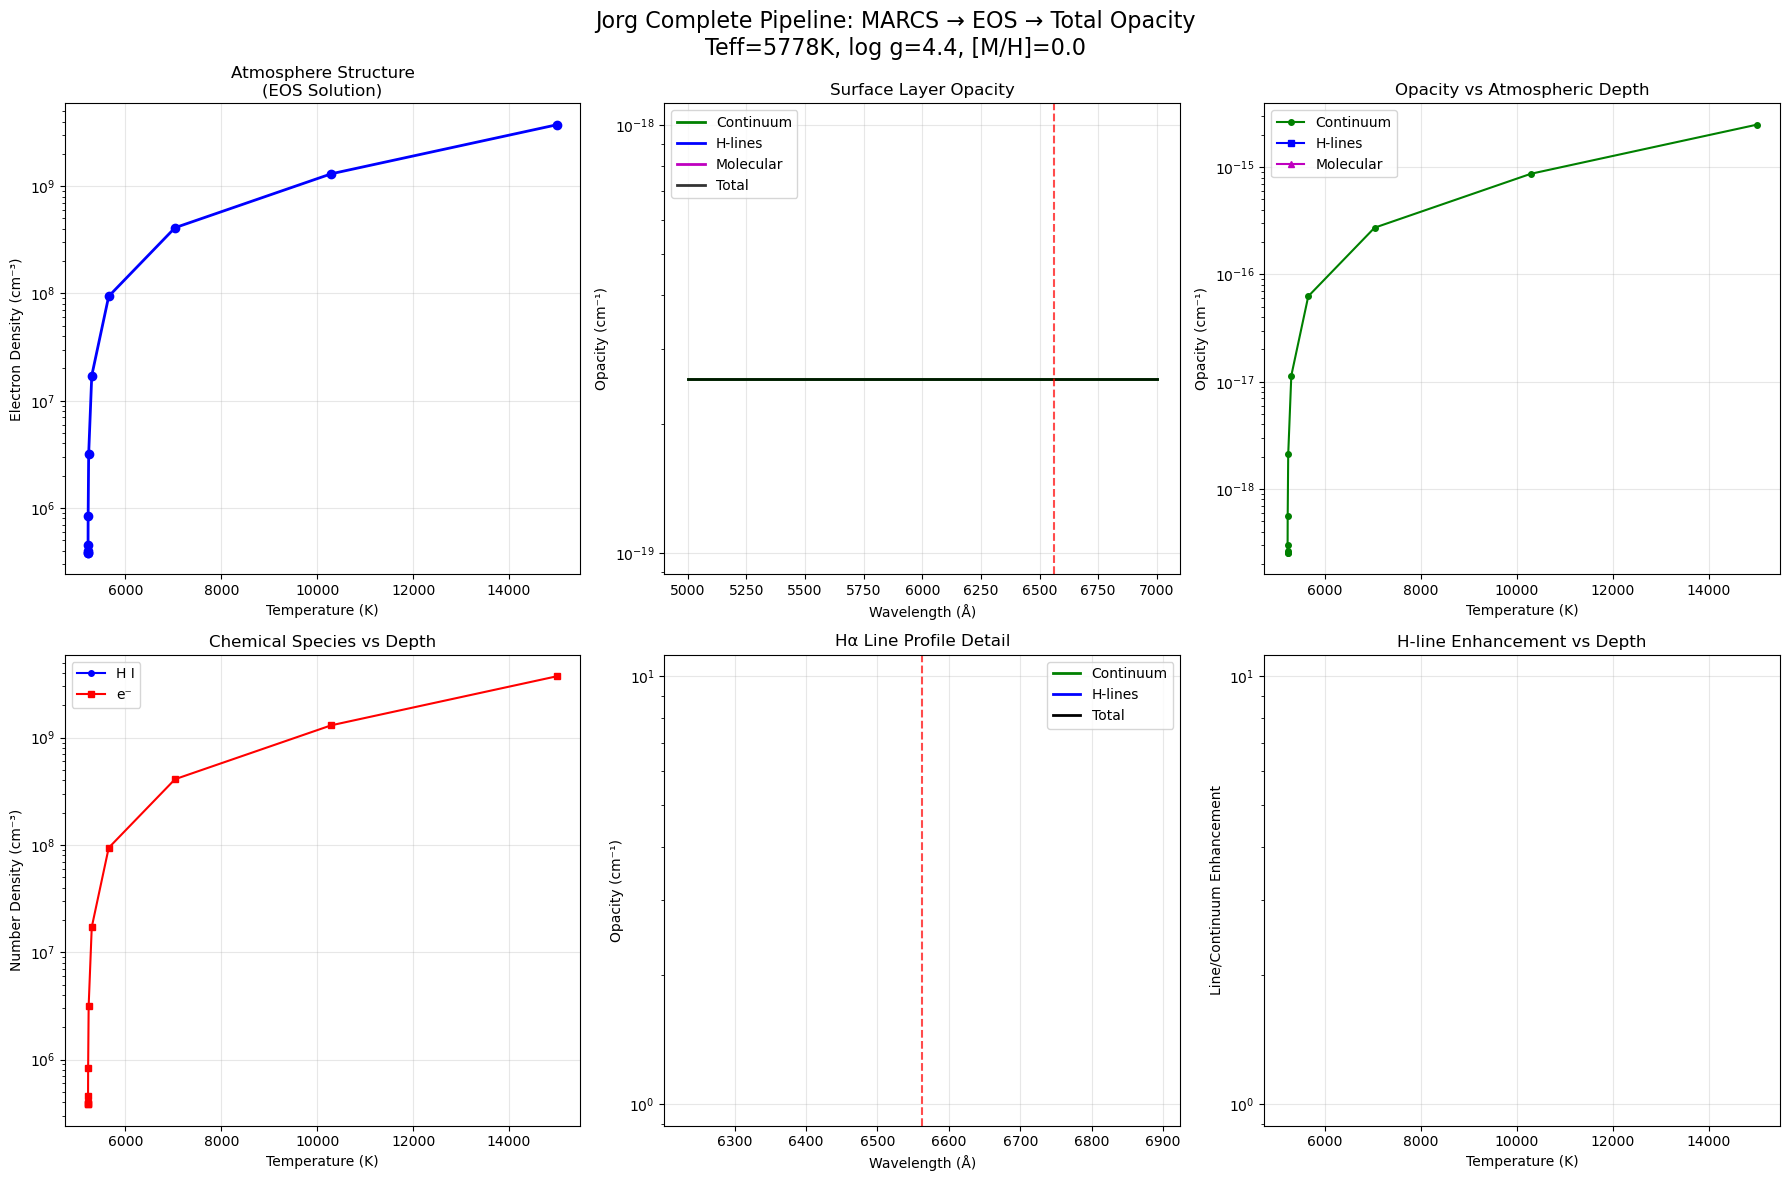

In [7]:
print(f"\n📊 STEP 4: Visualization and Analysis")
print("-" * 40)

try:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Jorg Complete Pipeline: MARCS → EOS → Total Opacity\n' +
                f'Teff={stellar_params["Teff"]:.0f}K, log g={stellar_params["logg"]:.1f}, ' +
                f'[M/H]={stellar_params["m_H"]:.1f}', fontsize=16)
    
    # Plot 1: Atmosphere structure
    ax1 = axes[0, 0]
    temps = [layer['temperature'] for layer in layer_solutions]
    electron_densities = [layer['electron_density'] for layer in layer_solutions]
    
    ax1.semilogy(temps, electron_densities, 'b-o', markersize=6, linewidth=2)
    ax1.set_xlabel('Temperature (K)')
    ax1.set_ylabel('Electron Density (cm⁻³)')
    ax1.set_title('Atmosphere Structure\n(EOS Solution)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Total opacity spectrum (surface)
    ax2 = axes[0, 1]
    ax2.semilogy(wavelengths_A, continuum_opacity[surface_layer], 'g-', 
                label='Continuum', linewidth=2)
    ax2.semilogy(wavelengths_A, hydrogen_opacity[surface_layer], 'b-', 
                label='H-lines', linewidth=2)
    ax2.semilogy(wavelengths_A, molecular_opacity[surface_layer], 'm-', 
                label='Molecular', linewidth=2)
    ax2.semilogy(wavelengths_A, total_opacity[surface_layer], 'k-', 
                label='Total', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Wavelength (Å)')
    ax2.set_ylabel('Opacity (cm⁻¹)')
    ax2.set_title('Surface Layer Opacity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axvline(6562.8, color='red', linestyle='--', alpha=0.7, label='Hα')
    
    # Plot 3: Opacity vs depth
    ax3 = axes[0, 2]
    cont_means = [jnp.mean(continuum_opacity[i]) for i in range(n_layers)]
    h_peaks = [jnp.max(hydrogen_opacity[i]) for i in range(n_layers)]
    mol_peaks = [jnp.max(molecular_opacity[i]) for i in range(n_layers)]
    
    ax3.semilogy(temps, cont_means, 'g-o', label='Continuum', markersize=4)
    ax3.semilogy(temps, h_peaks, 'b-s', label='H-lines', markersize=4)
    ax3.semilogy(temps, mol_peaks, 'm-^', label='Molecular', markersize=4)
    ax3.set_xlabel('Temperature (K)')
    ax3.set_ylabel('Opacity (cm⁻¹)')
    ax3.set_title('Opacity vs Atmospheric Depth')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Chemical equilibrium species
    ax4 = axes[1, 0]
    h1_densities = [layer['number_densities'].get('H_I', 0) for layer in layer_solutions]
    h2o_densities = [layer['number_densities'].get('H2O', 0) for layer in layer_solutions]
    
    ax4.semilogy(temps, h1_densities, 'b-o', label='H I', markersize=4)
    ax4.semilogy(temps, electron_densities, 'r-s', label='e⁻', markersize=4)
    if any(h2o > 0 for h2o in h2o_densities):
        ax4.semilogy(temps, h2o_densities, 'c-^', label='H₂O', markersize=4)
    ax4.set_xlabel('Temperature (K)')
    ax4.set_ylabel('Number Density (cm⁻³)')
    ax4.set_title('Chemical Species vs Depth')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Line profile detail (Hα region)
    ax5 = axes[1, 1]
    hα_region = (wavelengths_A > 6560) & (wavelengths_A < 6565)
    ax5.semilogy(wavelengths_A[hα_region], continuum_opacity[surface_layer][hα_region], 
                'g-', label='Continuum', linewidth=2)
    ax5.semilogy(wavelengths_A[hα_region], hydrogen_opacity[surface_layer][hα_region], 
                'b-', label='H-lines', linewidth=2)
    ax5.semilogy(wavelengths_A[hα_region], total_opacity[surface_layer][hα_region], 
                'k-', label='Total', linewidth=2)
    ax5.set_xlabel('Wavelength (Å)')
    ax5.set_ylabel('Opacity (cm⁻¹)')
    ax5.set_title('Hα Line Profile Detail')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.axvline(6562.8, color='red', linestyle='--', alpha=0.7)
    
    # Plot 6: Enhancement factors
    ax6 = axes[1, 2]
    enhancement_factors = []
    valid_indices = []
    
    for i in range(n_layers):
        cont_level = jnp.mean(continuum_opacity[i])
        line_peak = jnp.max(hydrogen_opacity[i])
        if cont_level > 0:
            enhancement = line_peak / cont_level
            enhancement_factors.append(enhancement)
            valid_indices.append(i)
    
    if enhancement_factors:
        valid_temps = [layer_solutions[i]['temperature'] for i in valid_indices]
        ax6.semilogy(valid_temps, enhancement_factors, 'purple', 
                    marker='o', linewidth=2, markersize=6)
        ax6.set_xlabel('Temperature (K)')
        ax6.set_ylabel('Line/Continuum Enhancement')
        ax6.set_title('H-line Enhancement vs Depth')
        ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()


except Exception as e:
        print(f"⚠️  Plotting failed: {e}")